In [2]:
using JuMP, HiGHS
using Plots;
using VegaLite  # to make some nice plots
using DataFrames, CSV, PrettyTables
include("../src/utils.jl")
include("../src/unit_commitments.jl")
include("../src/network_analysis.jl")
include("../src/plots.jl")
ENV["COLUMNS"]=120;

gen_df, gen_var_long, loads_long, network = process_data("../WECC")

zone_dict = Dict(zip(gen_df.zone, gen_df.zone_name));
line_dict = Dict(zip(network.network_lines, network."transmission path name"));

In [3]:
# A spring day
n=100
initial_time = n*24+6
final_time = n*24+30
T_period = (initial_time):(final_time)
gen_df = gen_df[gen_df.r_id .!= 119, :] # removes 29053 MW of hydro capacity (felt like cheating)
gen_df[gen_df.technology .== "Solar Photovoltaic", :existing_cap_mw] .*= 2.0
gen_df[gen_df.technology .== "Onshore Wind Turbine", :existing_cap_mw] .*= 4.0

loads_multi = loads_long[in.(loads_long.hour,Ref(T_period)),:]
gen_var_multi = gen_var_long[in.(gen_var_long.hour, Ref(T_period)), :]
uc_solution = uc_with_transport(
    gen_df, loads_multi, gen_var_multi, network, 0.01); #1% MIP Gap

Running HiGHS 1.11.0 (git hash: 364c83a51e): Copyright (c) 2025 HiGHS under MIT licence terms
MIP  has 51251 rows; 27275 cols; 153229 nonzeros; 10425 integer variables (10425 binary)
Coefficient ranges:
  Matrix [3e-01, 8e+03]
  Cost   [4e+00, 1e+06]
  Bound  [1e+00, 2e+03]
  RHS    [1e+00, 2e+04]
Presolving model
36917 rows, 26845 cols, 132367 nonzeros  0s
28029 rows, 21407 cols, 114599 nonzeros  0s
21092 rows, 19943 cols, 102264 nonzeros  0s
17849 rows, 16985 cols, 99295 nonzeros  1s
15901 rows, 15197 cols, 93519 nonzeros  3s

Solving MIP model with:
   15901 rows
   15197 cols (8696 binary, 0 integer, 0 implied int., 6501 continuous, 0 domain fixed)
   93519 nonzeros

Src: B => Branching; C => Central rounding; F => Feasibility pump; J => Feasibility jump;
     H => Heuristic; L => Sub-MIP; P => Empty MIP; R => Randomized rounding; Z => ZI Round;
     I => Shifting; S => Solve LP; T => Evaluate node; U => Unbounded; X => User solution;
     z => Trivial zero; l => Trivial lower; u =

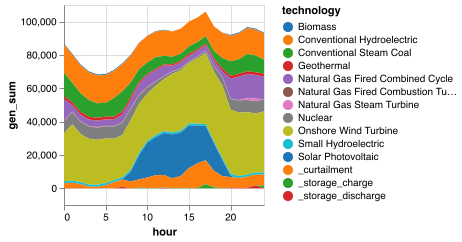

In [4]:
sol_gen = plot_total_generation(
    uc_solution, T_period,
    gen_df, zone_dict,
    "Generation without RUC "
    );

## Experiment: Compare RUC Timing Strategies - Lower Renewables Production

In [5]:
# lower renewables production case
gen_var_actuals = copy(gen_var_multi)
gen_var_actuals.cf .= gen_var_actuals.cf .* (0.8 .+ 0.1 .* rand(nrow(gen_var_actuals)));

In [6]:
# Strategy 1: No RUC - evaluate original UC on actual conditions
no_ruc_actual = evaluate_commitment_on_actuals(
    uc_solution,
    gen_df,
    loads_multi,
    gen_var_actuals,
    network,
    0.01
);

Running HiGHS 1.11.0 (git hash: 364c83a51e): Copyright (c) 2025 HiGHS under MIT licence terms
MIP  has 37779 rows; 20325 cols; 89121 nonzeros; 3475 integer variables (0 binary)
Coefficient ranges:
  Matrix [3e-01, 8e+03]
  Cost   [1e+00, 3e+03]
  Bound  [2e-15, 1e+00]
  RHS    [2e+00, 3e+05]
Presolving model
4509 rows, 4691 cols, 11985 nonzeros  0s
2041 rows, 4011 cols, 8249 nonzeros  0s
1422 rows, 3225 cols, 6357 nonzeros  0s
1422 rows, 3225 cols, 6357 nonzeros  0s

Solving MIP model with:
   1422 rows
   3225 cols (0 binary, 0 integer, 0 implied int., 3225 continuous, 0 domain fixed)
   6357 nonzeros

Src: B => Branching; C => Central rounding; F => Feasibility pump; J => Feasibility jump;
     H => Heuristic; L => Sub-MIP; P => Empty MIP; R => Randomized rounding; Z => ZI Round;
     I => Shifting; S => Solve LP; T => Evaluate node; U => Unbounded; X => User solution;
     z => Trivial zero; l => Trivial lower; u => Trivial upper; p => Trivial point

        Nodes      |    B&B Tree

In [7]:
# Strategy 2: Early RUC at hour 9
recommit_time_early = 9
recommit_hour_early = initial_time + recommit_time_early
T_period_ruc_early = recommit_hour_early:final_time

loads_ruc_early = loads_long[in.(loads_long.hour, Ref(T_period_ruc_early)), :]
gen_var_ruc_early = gen_var_long[in.(gen_var_long.hour, Ref(T_period_ruc_early)), :]

# Run RUC with forecast data from hour 9 onwards
ruc_solution_early = reliability_uc(
    uc_solution.decision_vars,
    recommit_hour_early,
    gen_df,
    loads_ruc_early,
    gen_var_ruc_early,
    network,
    0.01
)

# Evaluate on actual conditions
ruc_early_actual = evaluate_ruc_commitment_on_actuals(
    uc_solution,
    ruc_solution_early,
    recommit_hour_early,
    gen_df,
    loads_multi,
    gen_var_actuals,
    network,
    0.01
);

Running HiGHS 1.11.0 (git hash: 364c83a51e): Copyright (c) 2025 HiGHS under MIT licence terms
MIP  has 32898 rows; 17456 cols; 93446 nonzeros; 6672 integer variables (4566 binary)
Coefficient ranges:
  Matrix [3e-01, 8e+03]
  Cost   [4e+00, 1e+06]
  Bound  [4e-14, 2e+03]
  RHS    [4e-13, 2e+04]
Presolving model
17803 rows, 13582 cols, 55863 nonzeros  0s
12134 rows, 9891 cols, 44165 nonzeros  0s
8708 rows, 9055 cols, 39008 nonzeros  0s
7233 rows, 7859 cols, 35989 nonzeros  0s
6062 rows, 6749 cols, 33741 nonzeros  0s
5643 rows, 6516 cols, 32091 nonzeros  0s

Solving MIP model with:
   5643 rows
   6516 cols (3160 binary, 0 integer, 0 implied int., 3356 continuous, 0 domain fixed)
   32091 nonzeros

Src: B => Branching; C => Central rounding; F => Feasibility pump; J => Feasibility jump;
     H => Heuristic; L => Sub-MIP; P => Empty MIP; R => Randomized rounding; Z => ZI Round;
     I => Shifting; S => Solve LP; T => Evaluate node; U => Unbounded; X => User solution;
     z => Trivial zer

In [8]:
# Strategy 3: Late RUC at hour 16 (before evening peak)
recommit_time_late = 16
recommit_hour_late = initial_time + recommit_time_late
T_period_ruc_late = recommit_hour_late:final_time

loads_ruc_late = loads_long[in.(loads_long.hour, Ref(T_period_ruc_late)), :]
gen_var_ruc_late = gen_var_long[in.(gen_var_long.hour, Ref(T_period_ruc_late)), :]

# Run RUC with forecast data from hour 16 onwards
ruc_solution_late = reliability_uc(
    uc_solution.decision_vars,
    recommit_hour_late,
    gen_df,
    loads_ruc_late,
    gen_var_ruc_late,
    network,
    0.01
)

# Evaluate on actual conditions
ruc_late_actual = evaluate_ruc_commitment_on_actuals(
    uc_solution,
    ruc_solution_late,
    recommit_hour_late,
    gen_df,
    loads_multi,
    gen_var_actuals,
    network,
    0.01
);

Running HiGHS 1.11.0 (git hash: 364c83a51e): Copyright (c) 2025 HiGHS under MIT licence terms
MIP  has 18359 rows; 9819 cols; 49493 nonzeros; 3753 integer variables (2172 binary)
Coefficient ranges:
  Matrix [3e-01, 8e+03]
  Cost   [4e+00, 1e+06]
  Bound  [9e-14, 2e+03]
  RHS    [2e-13, 2e+04]
Presolving model
8436 rows, 6749 cols, 25159 nonzeros  0s
5288 rows, 4614 cols, 18510 nonzeros  0s
3675 rows, 4129 cols, 15747 nonzeros  0s
2996 rows, 3603 cols, 14687 nonzeros  0s
2478 rows, 3122 cols, 13718 nonzeros  0s
2313 rows, 2963 cols, 13332 nonzeros  0s

Solving MIP model with:
   2313 rows
   2963 cols (1298 binary, 0 integer, 0 implied int., 1665 continuous, 0 domain fixed)
   13332 nonzeros

Src: B => Branching; C => Central rounding; F => Feasibility pump; J => Feasibility jump;
     H => Heuristic; L => Sub-MIP; P => Empty MIP; R => Randomized rounding; Z => ZI Round;
     I => Shifting; S => Solve LP; T => Evaluate node; U => Unbounded; X => User solution;
     z => Trivial zero; l

In [9]:
comparison_df = DataFrame(
    Strategy = ["No RUC", "Early RUC (hour 9)", "Late RUC (hour 16)"],
    Total_Cost = [no_ruc_actual.objective, ruc_early_actual.objective, ruc_late_actual.objective],
    Load_Shed_MWh = [no_ruc_actual.total_loadshed, ruc_early_actual.total_loadshed, ruc_late_actual.total_loadshed],
    Curtailment_MWh = [no_ruc_actual.total_curtailment, ruc_early_actual.total_curtailment, ruc_late_actual.total_curtailment],
    CO2_Emissions_tons = [no_ruc_actual.total_co2, ruc_early_actual.total_co2, ruc_late_actual.total_co2]
);

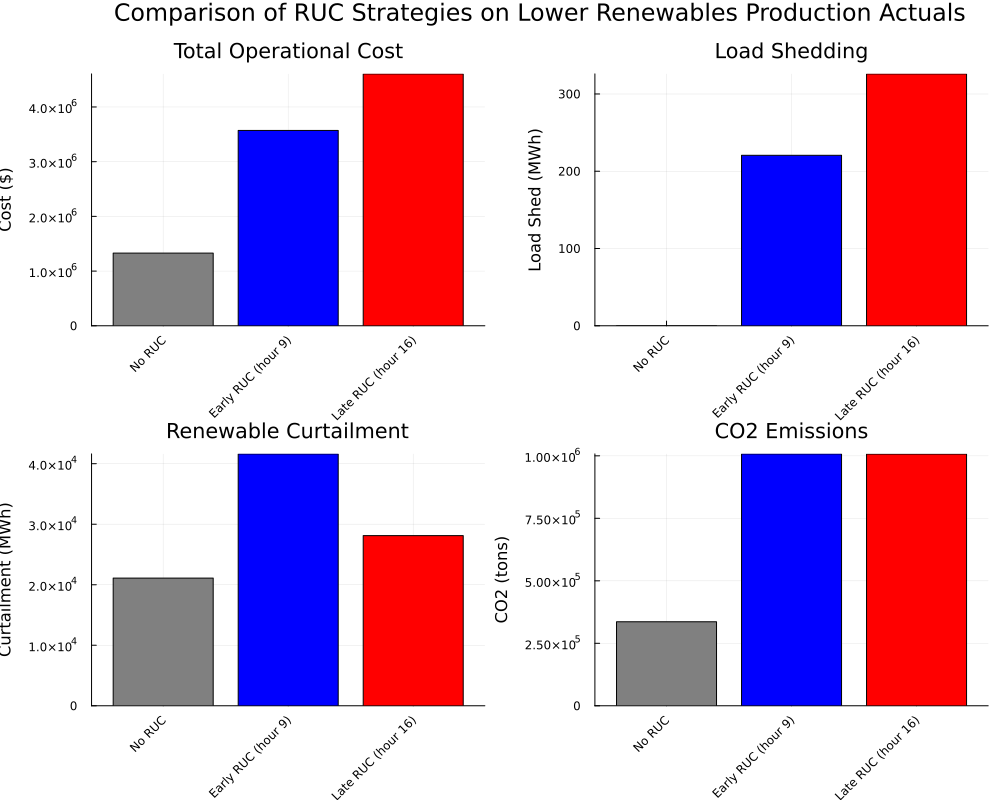

In [10]:
# Visualize performance metrics comparison
p1 = bar(comparison_df.Strategy, comparison_df.Total_Cost,
    title = "Total Operational Cost",
    ylabel = "Cost (\$)",
    legend = false,
    color = [:gray, :blue, :red],
    xrotation = 45
)

p2 = bar(comparison_df.Strategy, comparison_df.Load_Shed_MWh,
    title = "Load Shedding",
    ylabel = "Load Shed (MWh)",
    legend = false,
    color = [:gray, :blue, :red],
    xrotation = 45
)

p3 = bar(comparison_df.Strategy, comparison_df.Curtailment_MWh,
    title = "Renewable Curtailment",
    ylabel = "Curtailment (MWh)",
    legend = false,
    color = [:gray, :blue, :red],
    xrotation = 45
)

p4 = bar(comparison_df.Strategy, comparison_df.CO2_Emissions_tons,
    title = "CO2 Emissions",
    ylabel = "CO2 (tons)",
    legend = false,
    color = [:gray, :blue, :red],
    xrotation = 45
)

plot(p1, p2, p3, p4, layout = (2, 2), size = (1000, 800), 
     plot_title = "Comparison of RUC Strategies on Lower Renewables Production Actuals")

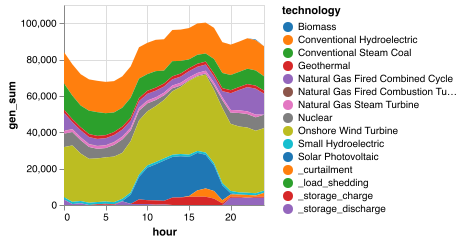

In [11]:
# Visual comparison of generation dispatch - No RUC
plot_actual_generation(
    no_ruc_actual,
    initial_time,
    gen_df,
    zone_dict,
    "Strategy 1: No RUC - Actual Generation on Lower Renewables Production ACtuals"
);

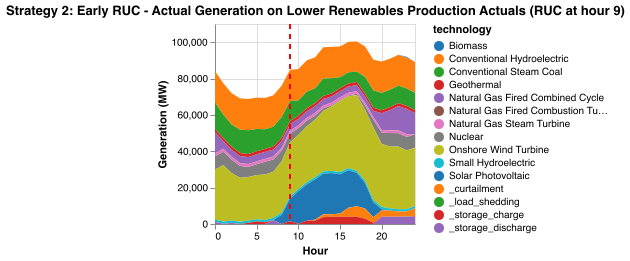

In [12]:
# Visual comparison - Early RUC (hour 9)
plot_actual_ruc_generation(
    ruc_early_actual,
    initial_time,
    recommit_time_early,
    gen_df,
    zone_dict,
    "Strategy 2: Early RUC - Actual Generation on Lower Renewables Production Actuals"
);

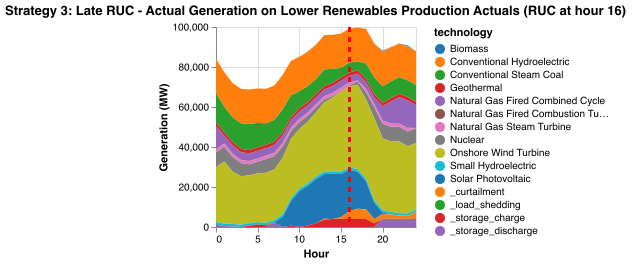

In [13]:
# Visual comparison - Late RUC (hour 16)
plot_actual_ruc_generation(
    ruc_late_actual,
    initial_time,
    recommit_time_late,
    gen_df,
    zone_dict,
    "Strategy 3: Late RUC - Actual Generation on Lower Renewables Production Actuals"
);

In [14]:
plots_dir = "lower_renewables"
if !isdir(plots_dir)
    mkpath(plots_dir)
end

plot_power_network(
    no_ruc_actual.flows,
    network,
    gen_df,
    zone_dict;
    hour=2418,
    save_path=joinpath(plots_dir, "NO_RUC.png")
)

plot_power_network(
    ruc_late_actual.flows,
    network,
    gen_df,
    zone_dict;
    hour=2418,
    save_path=joinpath(plots_dir, "HR16_RUC.png")
)

animate_power_network(
    no_ruc_actual.flows,
    network,
    gen_df,
    zone_dict;
    hours=2406:2430,
    save_path=joinpath(plots_dir, "NO_RUC_animation.gif")
)

animate_power_network(
    ruc_late_actual.flows,
    network,
    gen_df,
    zone_dict;
    hours=2406:2430,
    save_path=joinpath(plots_dir, "HR16_RUC_animation.gif")
)

plot_flow_heatmap(
    no_ruc_actual.flows,
    network,
    line_dict;
    save_path=joinpath(plots_dir, "NO_RUC_flow_heatmap.png")
)

plot_flow_heatmap(
    ruc_late_actual.flows,
    network,
    line_dict;
    save_path=joinpath(plots_dir, "HR16_RUC_flow_heatmap.png")
)

compare_network_flows(
    no_ruc_actual.flows,
    ruc_late_actual.flows,
    network,
    gen_df,
    zone_dict;
    hour=2418,
    save_path=joinpath(plots_dir, "flow_comparison.png")
)

[ Info: Saved animation to /Users/eddiek/Documents/GitHub/intraday-commitments/experiment_notebooks/lower_renewables/NO_RUC_animation.gif


Animation saved to lower_renewables/NO_RUC_animation.gif
Animation saved to lower_renewables/HR16_RUC_animation.gif
Animation saved to lower_renewables/HR16_RUC_animation.gif


[ Info: Saved animation to /Users/eddiek/Documents/GitHub/intraday-commitments/experiment_notebooks/lower_renewables/HR16_RUC_animation.gif


"/Users/eddiek/Documents/GitHub/intraday-commitments/experiment_notebooks/lower_renewables/flow_comparison.png"

## Experiment: Compare RUC Timing Strategies - Higher Renewables

In [15]:
# higher renewables production actuals case
gen_var_actuals = copy(gen_var_multi)
gen_var_actuals.cf .= gen_var_actuals.cf .* (1.2 .+ 0.1 .* rand(nrow(gen_var_actuals)));

In [16]:
# Strategy 1: No RUC - evaluate original UC on higher renewables production actuals
no_ruc_actual_high = evaluate_commitment_on_actuals(
    uc_solution,
    gen_df,
    loads_multi,
    gen_var_actuals,
    network,
    0.01
)

Running HiGHS 1.11.0 (git hash: 364c83a51e): Copyright (c) 2025 HiGHS under MIT licence terms
MIP  has 37779 rows; 20325 cols; 89121 nonzeros; 3475 integer variables (0 binary)
Coefficient ranges:
  Matrix [3e-01, 8e+03]
  Cost   [1e+00, 3e+03]
  Bound  [2e-15, 1e+00]
  RHS    [2e+00, 3e+05]
Presolving model
4533 rows, 4665 cols, 12007 nonzeros  0s
2063 rows, 3967 cols, 8245 nonzeros  0s
1439 rows, 3229 cols, 6391 nonzeros  0s
1417 rows, 3188 cols, 6304 nonzeros  0s

Solving MIP model with:
   1417 rows
   3188 cols (0 binary, 0 integer, 0 implied int., 3188 continuous, 0 domain fixed)
   6304 nonzeros

Src: B => Branching; C => Central rounding; F => Feasibility pump; J => Feasibility jump;
     H => Heuristic; L => Sub-MIP; P => Empty MIP; R => Randomized rounding; Z => ZI Round;
     I => Shifting; S => Solve LP; T => Evaluate node; U => Unbounded; X => User solution;
     z => Trivial zero; l => Trivial lower; u => Trivial upper; p => Trivial point

        Nodes      |    B&B Tree

(model = A JuMP Model
├ solver: HiGHS
├ objective_sense: MIN_SENSE
│ └ objective_function_type: AffExpr
├ num_variables: 20325
├ num_constraints: 60929
│ ├ AffExpr in MOI.EqualTo{Float64}: 3931
│ ├ AffExpr in MOI.GreaterThan{Float64}: 4175
│ ├ AffExpr in MOI.LessThan{Float64}: 29673
│ ├ VariableRef in MOI.EqualTo{Float64}: 3475
│ ├ VariableRef in MOI.GreaterThan{Float64}: 16200
│ └ VariableRef in MOI.ZeroOne: 3475
└ Names registered in the model
  └ :AuxGen, :CHARGE, :COMMIT, :Cap_nt_nonvar, :Cap_thermal_max, :Cap_thermal_min, :Cap_var, :ChargeCap, :DISCHARGE, :DischargeCap, :FLOW, :FlowMax, :FlowMin, :GEN, :GENAUX, :LOADSHED, :NodalBalance, :RESDN, :RESUP, :RampDn_nonthermal, :RampDn_thermal, :RampUp_nonthermal, :RampUp_thermal, :ResDnCap, :ResDnRamp, :ResDnRequirement, :ResUpCap, :ResUpRamp, :ResUpRequirement, :SOC, :SOCCap, :cStateOfCharge, :cStateOfChargeEnd, :cStateOfChargeStart, gen = 5025×3 DataFrame
  Row │ r_id   hour   gen      
      │ Int64  Int64  Float64  
──────┼────────

In [17]:
# Strategy 2: Early RUC at hour 9 (Higher Intermittency)
recommit_time_early_high = 9
recommit_hour_early_high = initial_time + recommit_time_early_high
T_period_ruc_early_high = recommit_hour_early_high:final_time

loads_ruc_early_high = loads_long[in.(loads_long.hour, Ref(T_period_ruc_early_high)), :]
gen_var_ruc_early_high = gen_var_long[in.(gen_var_long.hour, Ref(T_period_ruc_early_high)), :]

# Run RUC with forecast data from hour 9 onwards
ruc_solution_early_high = reliability_uc(
    uc_solution.decision_vars,
    recommit_hour_early_high,
    gen_df,
    loads_ruc_early_high,
    gen_var_ruc_early_high,
    network,
    0.01
)

# Evaluate on actual conditions
ruc_early_actual_high = evaluate_ruc_commitment_on_actuals(
    uc_solution,
    ruc_solution_early_high,
    recommit_hour_early_high,
    gen_df,
    loads_multi,
    gen_var_actuals,
    network,
    0.01
)

Running HiGHS 1.11.0 (git hash: 364c83a51e): Copyright (c) 2025 HiGHS under MIT licence terms
MIP  has 32898 rows; 17456 cols; 93446 nonzeros; 6672 integer variables (4566 binary)
Coefficient ranges:
  Matrix [3e-01, 8e+03]
  Cost   [4e+00, 1e+06]
  Bound  [4e-14, 2e+03]
  RHS    [4e-13, 2e+04]
Presolving model
17803 rows, 13582 cols, 55863 nonzeros  0s
12134 rows, 9891 cols, 44165 nonzeros  0s
8708 rows, 9055 cols, 39008 nonzeros  0s
7233 rows, 7859 cols, 35989 nonzeros  0s
6062 rows, 6749 cols, 33741 nonzeros  0s
5643 rows, 6516 cols, 32091 nonzeros  0s

Solving MIP model with:
   5643 rows
   6516 cols (3160 binary, 0 integer, 0 implied int., 3356 continuous, 0 domain fixed)
   32091 nonzeros

Src: B => Branching; C => Central rounding; F => Feasibility pump; J => Feasibility jump;
     H => Heuristic; L => Sub-MIP; P => Empty MIP; R => Randomized rounding; Z => ZI Round;
     I => Shifting; S => Solve LP; T => Evaluate node; U => Unbounded; X => User solution;
     z => Trivial zer

(model = A JuMP Model
├ solver: HiGHS
├ objective_sense: MIN_SENSE
│ └ objective_function_type: AffExpr
├ num_variables: 20325
├ num_constraints: 60929
│ ├ AffExpr in MOI.EqualTo{Float64}: 3931
│ ├ AffExpr in MOI.GreaterThan{Float64}: 4175
│ ├ AffExpr in MOI.LessThan{Float64}: 29673
│ ├ VariableRef in MOI.EqualTo{Float64}: 3475
│ ├ VariableRef in MOI.GreaterThan{Float64}: 16200
│ └ VariableRef in MOI.ZeroOne: 3475
└ Names registered in the model
  └ :AuxGen, :CHARGE, :COMMIT, :Cap_nt_nonvar, :Cap_thermal_max, :Cap_thermal_min, :Cap_var, :ChargeCap, :DISCHARGE, :DischargeCap, :FLOW, :FlowMax, :FlowMin, :GEN, :GENAUX, :LOADSHED, :NodalBalance, :RESDN, :RESUP, :RampDn_nonthermal, :RampDn_thermal, :RampUp_nonthermal, :RampUp_thermal, :ResDnCap, :ResDnRamp, :ResDnRequirement, :ResUpCap, :ResUpRamp, :ResUpRequirement, :SOC, :SOCCap, :cStateOfCharge, :cStateOfChargeEnd, :cStateOfChargeStart, gen = 5025×3 DataFrame
  Row │ r_id   hour   gen      
      │ Int64  Int64  Float64  
──────┼────────

In [18]:
# Strategy 3: Late RUC at hour 16 (Higher Intermittency)
recommit_time_late_high = 16
recommit_hour_late_high = initial_time + recommit_time_late_high
T_period_ruc_late_high = recommit_hour_late_high:final_time

loads_ruc_late_high = loads_long[in.(loads_long.hour, Ref(T_period_ruc_late_high)), :]
gen_var_ruc_late_high = gen_var_long[in.(gen_var_long.hour, Ref(T_period_ruc_late_high)), :]

# Run RUC with forecast data from hour 16 onwards
ruc_solution_late_high = reliability_uc(
    uc_solution.decision_vars,
    recommit_hour_late_high,
    gen_df,
    loads_ruc_late_high,
    gen_var_ruc_late_high,
    network,
    0.01
)

# Evaluate on actual conditions
ruc_late_actual_high = evaluate_ruc_commitment_on_actuals(
    uc_solution,
    ruc_solution_late_high,
    recommit_hour_late_high,
    gen_df,
    loads_multi,
    gen_var_actuals,
    network,
    0.01
)

Running HiGHS 1.11.0 (git hash: 364c83a51e): Copyright (c) 2025 HiGHS under MIT licence terms
MIP  has 18359 rows; 9819 cols; 49493 nonzeros; 3753 integer variables (2172 binary)
Coefficient ranges:
  Matrix [3e-01, 8e+03]
  Cost   [4e+00, 1e+06]
  Bound  [9e-14, 2e+03]
  RHS    [2e-13, 2e+04]
Presolving model
8436 rows, 6749 cols, 25159 nonzeros  0s
5288 rows, 4614 cols, 18510 nonzeros  0s
3675 rows, 4129 cols, 15747 nonzeros  0s
2996 rows, 3603 cols, 14687 nonzeros  0s
2478 rows, 3122 cols, 13718 nonzeros  0s
2313 rows, 2963 cols, 13332 nonzeros  0s

Solving MIP model with:
   2313 rows
   2963 cols (1298 binary, 0 integer, 0 implied int., 1665 continuous, 0 domain fixed)
   13332 nonzeros

Src: B => Branching; C => Central rounding; F => Feasibility pump; J => Feasibility jump;
     H => Heuristic; L => Sub-MIP; P => Empty MIP; R => Randomized rounding; Z => ZI Round;
     I => Shifting; S => Solve LP; T => Evaluate node; U => Unbounded; X => User solution;
     z => Trivial zero; l

(model = A JuMP Model
├ solver: HiGHS
├ objective_sense: MIN_SENSE
│ └ objective_function_type: AffExpr
├ num_variables: 20325
├ num_constraints: 60929
│ ├ AffExpr in MOI.EqualTo{Float64}: 3931
│ ├ AffExpr in MOI.GreaterThan{Float64}: 4175
│ ├ AffExpr in MOI.LessThan{Float64}: 29673
│ ├ VariableRef in MOI.EqualTo{Float64}: 3475
│ ├ VariableRef in MOI.GreaterThan{Float64}: 16200
│ └ VariableRef in MOI.ZeroOne: 3475
└ Names registered in the model
  └ :AuxGen, :CHARGE, :COMMIT, :Cap_nt_nonvar, :Cap_thermal_max, :Cap_thermal_min, :Cap_var, :ChargeCap, :DISCHARGE, :DischargeCap, :FLOW, :FlowMax, :FlowMin, :GEN, :GENAUX, :LOADSHED, :NodalBalance, :RESDN, :RESUP, :RampDn_nonthermal, :RampDn_thermal, :RampUp_nonthermal, :RampUp_thermal, :ResDnCap, :ResDnRamp, :ResDnRequirement, :ResUpCap, :ResUpRamp, :ResUpRequirement, :SOC, :SOCCap, :cStateOfCharge, :cStateOfChargeEnd, :cStateOfChargeStart, gen = 5025×3 DataFrame
  Row │ r_id   hour   gen      
      │ Int64  Int64  Float64  
──────┼────────

In [19]:
comparison_df_high = DataFrame(
    Strategy = ["No RUC", "Early RUC (hour 9)", "Late RUC (hour 16)"],
    Total_Cost = [no_ruc_actual_high.objective, ruc_early_actual_high.objective, ruc_late_actual_high.objective],
    Load_Shed_MWh = [no_ruc_actual_high.total_loadshed, ruc_early_actual_high.total_loadshed, ruc_late_actual_high.total_loadshed],
    Curtailment_MWh = [no_ruc_actual_high.total_curtailment, ruc_early_actual_high.total_curtailment, ruc_late_actual_high.total_curtailment],
    CO2_Emissions_tons = [no_ruc_actual_high.total_co2, ruc_early_actual_high.total_co2, ruc_late_actual_high.total_co2]
)


Row,Strategy,Total_Cost,Load_Shed_MWh,Curtailment_MWh,CO2_Emissions_tons
,String,Float64,Float64,Float64,Float64
1,No RUC,8.96864e5,0.0,303823.0,2.55007e5
2,Early RUC (hour 9),9.39918e5,0.0,3.17711e5,9.98234e5
3,Late RUC (hour 16),9.09546e5,0.0,2.84277e5,9.97806e5


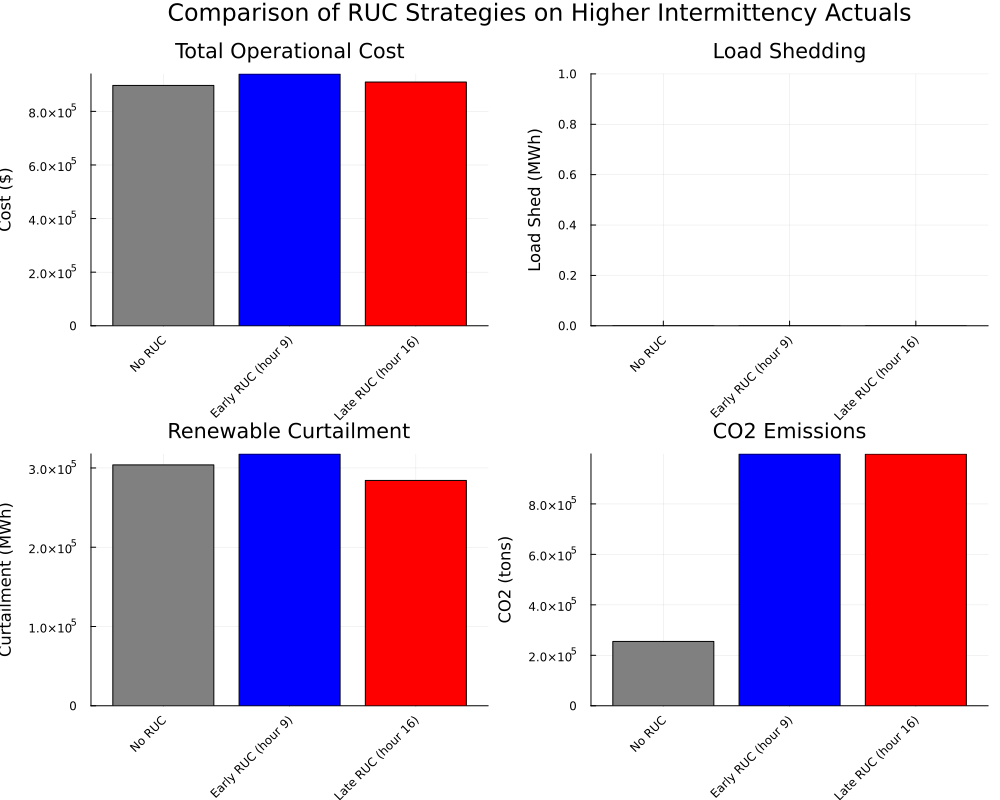

In [20]:
# Visualize performance metrics comparison - Higher Intermittency
p1_high = bar(comparison_df_high.Strategy, comparison_df_high.Total_Cost,
    title = "Total Operational Cost",
    ylabel = "Cost (\$)",
    legend = false,
    color = [:gray, :blue, :red],
    xrotation = 45
)

p2_high = bar(comparison_df_high.Strategy, comparison_df_high.Load_Shed_MWh,
    title = "Load Shedding",
    ylabel = "Load Shed (MWh)",
    legend = false,
    color = [:gray, :blue, :red],
    xrotation = 45
)

p3_high = bar(comparison_df_high.Strategy, comparison_df_high.Curtailment_MWh,
    title = "Renewable Curtailment",
    ylabel = "Curtailment (MWh)",
    legend = false,
    color = [:gray, :blue, :red],
    xrotation = 45
)

p4_high = bar(comparison_df_high.Strategy, comparison_df_high.CO2_Emissions_tons,
    title = "CO2 Emissions",
    ylabel = "CO2 (tons)",
    legend = false,
    color = [:gray, :blue, :red],
    xrotation = 45
)

plot(p1_high, p2_high, p3_high, p4_high, layout = (2, 2), size = (1000, 800), 
     plot_title = "Comparison of RUC Strategies on Higher Intermittency Actuals")

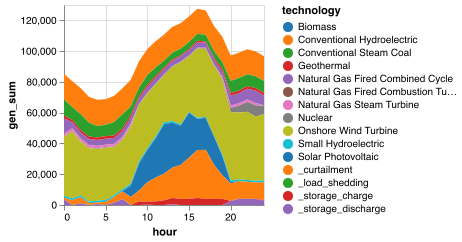

In [21]:
# Visual comparison of generation dispatch - No RUC (Higher Intermittency)
plot_actual_generation(
    no_ruc_actual_high,
    initial_time,
    gen_df,
    zone_dict,
    "Strategy 1: No RUC - Actual Generation on Higher Intermittency"
);

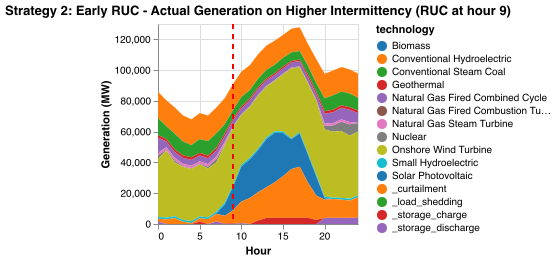

In [22]:
# Visual comparison - Early RUC (hour 9) - Higher Intermittency
plot_actual_ruc_generation(
    ruc_early_actual_high,
    initial_time,
    recommit_time_early_high,
    gen_df,
    zone_dict,
    "Strategy 2: Early RUC - Actual Generation on Higher Intermittency"
);

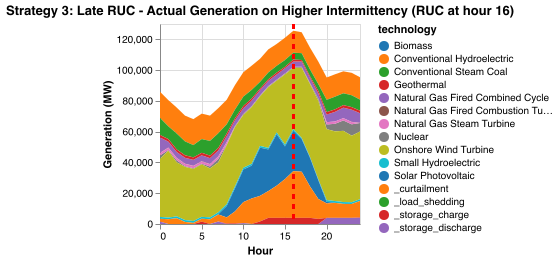

In [23]:
# Visual comparison - Late RUC (hour 16) - Higher Intermittency
plot_actual_ruc_generation(
    ruc_late_actual_high,
    initial_time,
    recommit_time_late_high,
    gen_df,
    zone_dict,
    "Strategy 3: Late RUC - Actual Generation on Higher Intermittency"
);

In [26]:
plots_dir = "higher_renewables"
if !isdir(plots_dir)
    mkpath(plots_dir)
end

plot_power_network(
    no_ruc_actual.flows,
    network,
    gen_df,
    zone_dict;
    hour=2418,
    save_path=joinpath(plots_dir, "NO_RUC.png")
)

plot_power_network(
    ruc_late_actual.flows,
    network,
    gen_df,
    zone_dict;
    hour=2418,
    save_path=joinpath(plots_dir, "HR16_RUC.png")
)

animate_power_network(
    no_ruc_actual.flows,
    network,
    gen_df,
    zone_dict;
    hours=2406:2430,
    save_path=joinpath(plots_dir, "NO_RUC_animation.gif")
)

animate_power_network(
    ruc_late_actual.flows,
    network,
    gen_df,
    zone_dict;
    hours=2406:2430,
    save_path=joinpath(plots_dir, "HR16_RUC_animation.gif")
)

plot_flow_heatmap(
    no_ruc_actual.flows,
    network,
    line_dict;
    save_path=joinpath(plots_dir, "NO_RUC_flow_heatmap.png")
)

plot_flow_heatmap(
    ruc_late_actual.flows,
    network,
    line_dict;
    save_path=joinpath(plots_dir, "HR16_RUC_flow_heatmap.png")
)

compare_network_flows(
    no_ruc_actual.flows,
    ruc_late_actual.flows,
    network,
    gen_df,
    zone_dict;
    hour=2418,
    save_path=joinpath(plots_dir, "flow_comparison.png")
)

Animation saved to higher_renewables/NO_RUC_animation.gif


[ Info: Saved animation to /Users/eddiek/Documents/GitHub/intraday-commitments/experiment_notebooks/higher_renewables/NO_RUC_animation.gif


Animation saved to higher_renewables/HR16_RUC_animation.gif


[ Info: Saved animation to /Users/eddiek/Documents/GitHub/intraday-commitments/experiment_notebooks/higher_renewables/HR16_RUC_animation.gif


"/Users/eddiek/Documents/GitHub/intraday-commitments/experiment_notebooks/higher_renewables/flow_comparison.png"


Best Strategy Based on Load Shedding (Higher Intermittency): No RUC


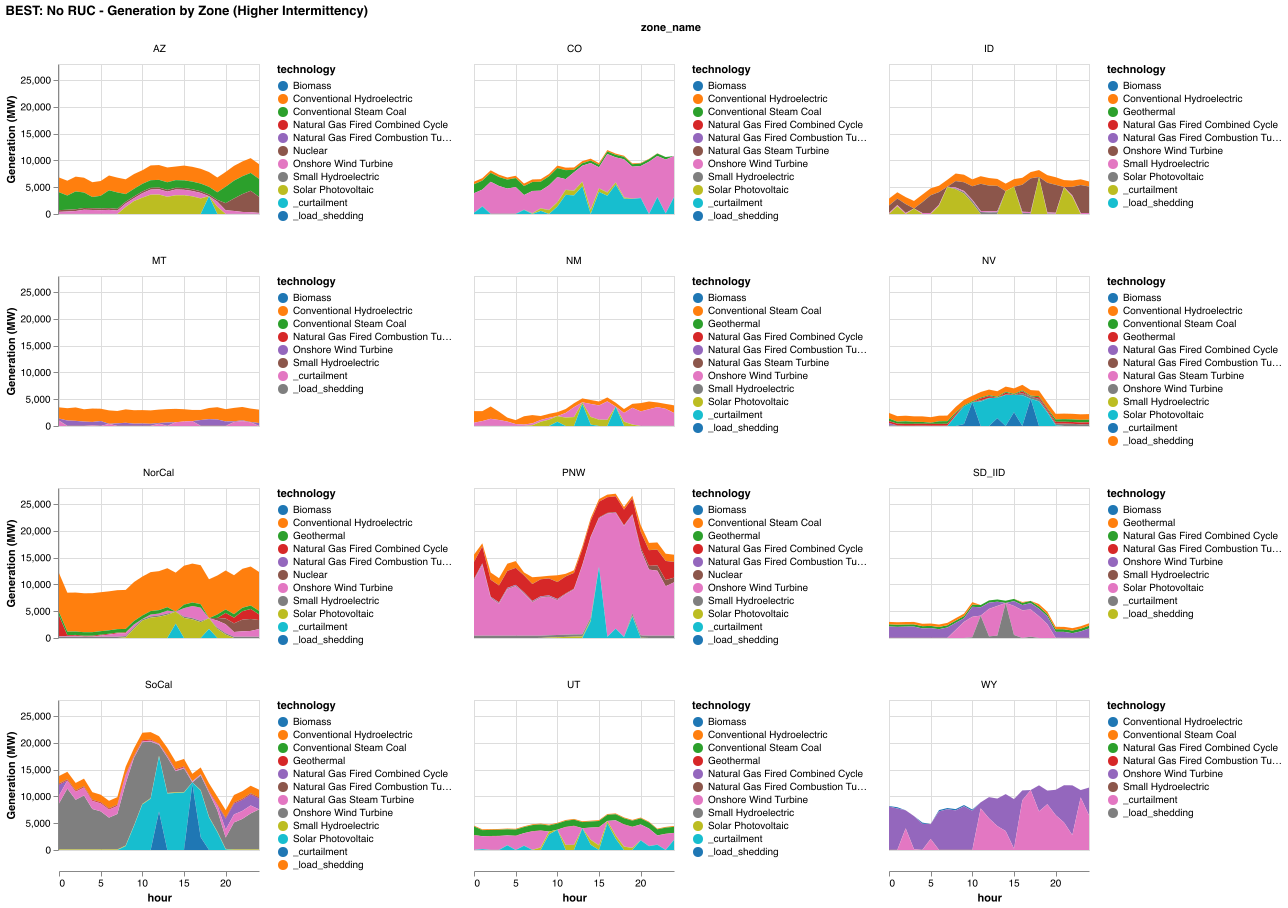

In [24]:
# Zone-by-zone comparison for best strategy - Higher Intermittency
best_strategy_idx_high = argmin([no_ruc_actual_high.total_loadshed, ruc_early_actual_high.total_loadshed, ruc_late_actual_high.total_loadshed])
best_strategy_name_high = ["No RUC", "Early RUC (hour 9)", "Late RUC (hour 16)"][best_strategy_idx_high]
best_solution_high = [no_ruc_actual_high, ruc_early_actual_high, ruc_late_actual_high][best_strategy_idx_high]

println("\nBest Strategy Based on Load Shedding (Higher Intermittency): $best_strategy_name_high")

if best_strategy_idx_high == 1
    plot_actual_generation_by_zone(
        best_solution_high,
        initial_time,
        gen_df,
        zone_dict,
        "BEST: $best_strategy_name_high - Generation by Zone (Higher Intermittency)"
    )
else
    recommit_time_best_high = [0, recommit_time_early_high, recommit_time_late_high][best_strategy_idx_high]
    plot_actual_ruc_generation_by_zone(
        best_solution_high,
        initial_time,
        recommit_time_best_high,
        gen_df,
        zone_dict,
        "BEST: $best_strategy_name_high - Generation by Zone (Higher Intermittency)"
    )
end;